## Deep Convolutional Generative Adversarial Network
In this notebook I will be going over a simple deep convolutional GAN. I know this isnt part of the content we have covered in the last two weeks but since I didn't do my report on GANs last report so I wanted to spend some time covering them for myself. This tutorial will be creating a DCGAN based on the paper we covered in class ([Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf)).

## What are GANs?

Generative modeling is an unsupervised learning task that can automatically discover and learn the patterns of input data such that it can later generate new images that appear like they could be of the initial input dataset.

GANs are a clever way of training a generative model by framing the problem as a supervised learning problem with two sub-models: the generator model that we train to generate new examples, and the discriminator model that tries to classify examples as either real (from the domain) or fake (generated). The two models are trained together in a zero-sum game, adversarial, until the discriminator model is fooled about half the time, meaning the generator model is generating plausible examples.

The following image was in the original notebook of this tutorial and I felt like it was a simple way to understand GANs so I left it in.


![A diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)



## Difference between DCGAN and GAN
A Deep Convolution GAN does something similar to a GAN, but specifically focusses on using deep convolutional networks instead of those fully-connected networks. The convolutional nets in can find areas of correlation within an image. This means a DCGAN would likely be more fitting for this application of hand drawn numbers whereas a normal GAN could be more applicable in a variety of other domains.


This notebook demonstrates this process on the MNIST dataset, which is simply a large dataset of handwritten single digits. The following animation shows a series of images produced by the generator as it was trained for 100 epochs. The images begin as random noise, and increasingly resemble hand written digits over time. From my own experiance working through this tutorial, I found that the numbers still improve a lot up until 100 epochs so that is how long I trained my model for.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)


### Setup

In [1]:
import tensorflow as tf

In [2]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_z175uhl
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-_z175uhl
     |████████████████████████████████| 1.0MB 10.9MB/s 
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.045d70633a51e5dd0e27cb5f1e1f19fc168c03b6c_-cp37-none-any.whl size=149186 sha256=77fa465b4a7d435d5689fb350928bdfcbf2012e9e5bc87cf659437f2c41e23f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-liyk5wad/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

As mentioned above, we will be using the MNIST dataset. The generator will generate handwritten digits resembling the MNIST data.

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


11493376/11490434 [==============================] - 1s 0us/step


Below is just a sample of the data to see what we are dealing with.

In [5]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [6]:
#reshape and change to float
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5  

In [7]:
# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses transposed 2d convolutional (upsampling) layers to produce an image from a seed that is essentially just random noise. The purpose of upsampling is to manipulate a signal in order to artificially increase the sampling rate. Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. This model will also use the leaky relu activation function at each layer, except the output layer which uses tanh. Leaky relu is designed such that it will be able to avoid the "dead neuron" problem that relu often runs into.

We will also be using two transposed 2d convolutional layers. The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution. Meaning that a good use for them is to go from something that has the shape of the output of some convolution to something that has the shape of its input while keeping the same connectivity of the convolution.

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Below we create an image from the untrained generator. As we expect it appears to be completely full of noise.

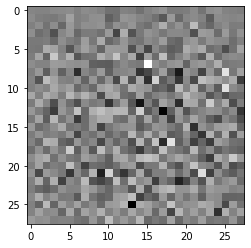

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the untrained discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[8.810783e-05]], shape=(1, 1), dtype=float32)


I am surprised to see that the value outputted is not clearly negative. It seems to average out to be 0, but since the generated image is just noise, I would expect a significantly negative number.

## Define the loss and optimizers

Using the binary crossentropy because we only have two classes, positive and negative.


In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on generated images to an array of 0s. It then returns the number of false guesses.

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real. Here, compare the discriminators decisions on the generated images to an array of 1s.

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Use the Adam optimizer for both the generator and descriminator.

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
#checkpoint model (not necessary)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training Helpers


In [17]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image that appears random. The discriminator is then used to classify real images and generated images. The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

## Training
The following cell will train the model for 100 epochs if you do not change the number. I chose 100 because at 50 the images were still a little unclear as to what digit they were supposed to be. This function will also display the most recent generated images. There is no need to see them all at once since I combine them into a GIF later to see the evolution more clearly.

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

## Generate and save images


In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
The following cell will train the generator and discriminator simultaneously. Training GANs can in some cases be difficult because since they train at the same time, the generator and discriminator can potentially overpower each other. Thus, the goal is for them to train at roughly the same rate.

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they start to resemble MNIST digits. However, it seemed to take until 100 epochs for them to be largely decipherable with the human eye, in my opinion. There are still those that may not be apparent as a digit, but I would say most of them are.

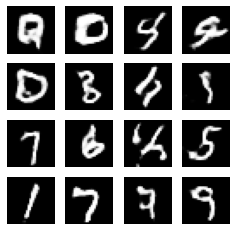

In [21]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [22]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [23]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

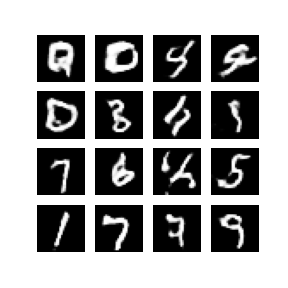

In [24]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [25]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


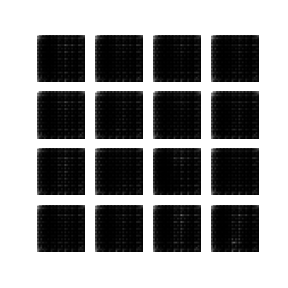

In [26]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Final Thoughts
The idea behind a GAN that you are training the generator to essentially be able to trick the descriminator is a very cool idea to me. 

As a side note, I have long followed the company Tesla just since I think the advent of electric vehicles is a fascinating topic. Because of that I have dug deep into the innerworkings of Tesla as a business and their autonomous vehicle capabilities. As you may know, they are building a super computer called Dojo to better train their self driving AI. One of the advantages Tesla has as a company is that they have collected so much more data to train their AI than other car manufactorers. Since the company with the most/best data will likely be the first to get real self driving and the other companies are so far behind, would it be possible/worth it for companies to try and use GANs to generate data to then train their self driving AIs? I am guessing that there are probably way more challenges than benefits so I am assuming companies would not do this but I was just thinking that it seems like a useful application of a GAN.